# Structured and time series data

This notebook contains an implementation of the third place result in the Rossman Kaggle competition as detailed in Guo/Berkhahn's [Entity Embeddings of Categorical Variables](https://arxiv.org/abs/1604.06737).

The motivation behind exploring this architecture is it's relevance to real-world application. Most data used for decision making day-to-day in industry is structured and/or time-series data. Here we explore the end-to-end process of using neural networks with practical structured data problems.

Fully connected Net or RNN (LSTM)?

https://forums.fast.ai/t/time-series-structure-data-with-lstm/11975

What you’re referring to is known as “auto-regression”. That is, using earlier time periods of the dependent variable as predictors. It is indeed common in time series, but not directly doable with the kind of model used in this notebook. For that, you’d need an RNN, which is introduced next! :slight_smile: (However, it seems that in practice RNNs aren’t giving as good results as fully connected nets for this kind of data.)

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.structured import *
from fastai.column_data import *
np.set_printoptions(threshold=50, edgeitems=20)

PATH='data/rossmann/'

In [113]:
!ls {PATH}

df		 models			store.csv	  train.csv
googletrend.csv  rossmann.tgz		store_states.csv  weather.csv
joined		 sample_submission.csv	test.csv
joined_test	 state_names.csv	tmp


## Create datasets

In addition to the provided data, we will be using external datasets put together by participants in the Kaggle competition. You can download all of them [here](http://files.fast.ai/part2/lesson14/rossmann.tgz).

For completeness, the implementation used to put them together is included below.

In [3]:
def concat_csvs(dirname):
    path = f'{PATH}{dirname}'
    filenames=glob(f"{PATH}/*.csv")

    wrote_header = False
    with open(f"{path}.csv","w") as outputfile:
        for filename in filenames:
            name = filename.split(".")[0]
            with open(filename) as f:
                line = f.readline()
                if not wrote_header:
                    wrote_header = True
                    outputfile.write("file,"+line)
                for line in f:
                     outputfile.write(name + "," + line)
                outputfile.write("\n")

In [4]:
#concat_csvs('googletrend')
#concat_csvs('weather')

Feature Space:
* train: Training set provided by competition
* store: List of stores
* store_states: mapping of store to the German state they are in
* List of German state names
* googletrend: trend of certain google keywords over time, found by users to correlate well w/ given data
* weather: weather
* test: testing set

In [15]:
table_names = ['train', 'store', 'store_states', 'state_names', 
               'googletrend', 'weather', 'test']

We'll be using the popular data manipulation framework `pandas`. Among other things, pandas allows you to manipulate tables/data frames in python as one would in a database.

We're going to go ahead and load all of our csv's as dataframes into the list `tables`.

In [16]:

tables = [pd.read_csv(f'{PATH}{fname}.csv', low_memory=False) for fname in table_names]

In [17]:
from IPython.display import HTML, display

We can use `head()` to get a quick look at the contents of each table:
* train: Contains store information on a daily basis, tracks things like sales, customers, whether that day was a holdiay, etc.
* store: general info about the store including competition, etc.
* store_states: maps store to state it is in
* state_names: Maps state abbreviations to names
* googletrend: trend data for particular week/state
* weather: weather conditions for each state
* test: Same as training table, w/o sales and customers


In [18]:
for t in tables: display(t.head())

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


,Store,State
0,1,HE
1,2,TH
2,3,NW
3,4,BE
4,5,SN


,StateName,State
0,BadenWuerttemberg,BW
1,Bayern,BY
2,Berlin,BE
3,Brandenburg,BB
4,Bremen,HB


,file,week,trend
0,Rossmann_DE_SN,2012-12-02 - 2012-12-08,96
1,Rossmann_DE_SN,2012-12-09 - 2012-12-15,95
2,Rossmann_DE_SN,2012-12-16 - 2012-12-22,91
3,Rossmann_DE_SN,2012-12-23 - 2012-12-29,48
4,Rossmann_DE_SN,2012-12-30 - 2013-01-05,67


,file,Date,Max_TemperatureC,Mean_TemperatureC,Min_TemperatureC,Dew_PointC,MeanDew_PointC,Min_DewpointC,Max_Humidity,Mean_Humidity,...,Max_VisibilityKm,Mean_VisibilityKm,Min_VisibilitykM,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,Max_Gust_SpeedKm_h,Precipitationmm,CloudCover,Events,WindDirDegrees
0,NordrheinWestfalen,2013-01-01,8,4,2,7,5,1,94,87,...,31.0,12.0,4.0,39,26,58.0,5.08,6.0,Rain,215
1,NordrheinWestfalen,2013-01-02,7,4,1,5,3,2,93,85,...,31.0,14.0,10.0,24,16,NaN,0.00,6.0,Rain,225
2,NordrheinWestfalen,2013-01-03,11,8,6,10,8,4,100,93,...,31.0,8.0,2.0,26,21,NaN,1.02,7.0,Rain,240
3,NordrheinWestfalen,2013-01-04,9,9,8,9,9,8,100,94,...,11.0,5.0,2.0,23,14,NaN,0.25,7.0,Rain,263
4,NordrheinWestfalen,2013-01-05,8,8,7,8,7,6,100,94,...,10.0,6.0,3.0,16,10,NaN,0.00,7.0,Rain,268


,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


This is very representative of a typical industry dataset.

The following returns summarized aggregate information to each table accross each field.

In [19]:
for t in tables: display(DataFrameSummary(t).summary())

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
count,1.01721e+06,1.01721e+06,NaN,1.01721e+06,1.01721e+06,1.01721e+06,1.01721e+06,NaN,1.01721e+06
mean,558.43,3.99834,NaN,5773.82,633.146,0.830107,0.381515,NaN,0.178647
std,321.909,1.99739,NaN,3849.93,464.412,0.375539,0.485759,NaN,0.383056
min,1,1,NaN,0,0,0,0,NaN,0
25%,280,2,NaN,3727,405,1,0,NaN,0
50%,558,4,NaN,5744,609,1,0,NaN,0
75%,838,6,NaN,7856,837,1,1,NaN,0
max,1115,7,NaN,41551,7388,1,1,NaN,1
counts,1017209,1017209,1017209,1017209,1017209,1017209,1017209,1017209,1017209
uniques,1115,7,942,21734,4086,2,2,4,2


,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
count,1115,NaN,NaN,1112,761,761,1115,571,571,NaN
mean,558,NaN,NaN,5404.9,7.2247,2008.67,0.512108,23.5954,2011.76,NaN
std,322.017,NaN,NaN,7663.17,3.21235,6.19598,0.500078,14.142,1.67494,NaN
min,1,NaN,NaN,20,1,1900,0,1,2009,NaN
25%,279.5,NaN,NaN,717.5,4,2006,0,13,2011,NaN
50%,558,NaN,NaN,2325,8,2010,1,22,2012,NaN
75%,836.5,NaN,NaN,6882.5,10,2013,1,37,2013,NaN
max,1115,NaN,NaN,75860,12,2015,1,50,2015,NaN
counts,1115,1115,1115,1112,761,761,1115,571,571,571
uniques,1115,4,3,654,12,23,2,24,7,3


,Store,State
count,1115,NaN
mean,558,NaN
std,322.017,NaN
min,1,NaN
25%,279.5,NaN
50%,558,NaN
75%,836.5,NaN
max,1115,NaN
counts,1115,1115
uniques,1115,12


,StateName,State
count,16,16
unique,16,16
top,NordrheinWestfalen,RP
freq,1,1
counts,16,16
uniques,16,16
missing,0,0
missing_perc,0%,0%
types,unique,unique


,file,week,trend
count,NaN,NaN,2072
mean,NaN,NaN,63.8142
std,NaN,NaN,12.6502
min,NaN,NaN,0
25%,NaN,NaN,55
50%,NaN,NaN,64
75%,NaN,NaN,72
max,NaN,NaN,100
counts,2072,2072,2072
uniques,14,148,68


,file,Date,Max_TemperatureC,Mean_TemperatureC,Min_TemperatureC,Dew_PointC,MeanDew_PointC,Min_DewpointC,Max_Humidity,Mean_Humidity,...,Max_VisibilityKm,Mean_VisibilityKm,Min_VisibilitykM,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,Max_Gust_SpeedKm_h,Precipitationmm,CloudCover,Events,WindDirDegrees
count,NaN,NaN,15840,15840,15840,15840,15840,15840,15840,15840,...,15459,15459,15459,15840,15840,3604,15840,14667,NaN,15840
mean,NaN,NaN,14.6441,10.389,6.19899,8.58782,6.20581,3.62614,93.6596,74.2829,...,24.0576,12.2398,7.02516,22.7666,11.9722,48.8643,0.831718,5.55131,NaN,175.897
std,NaN,NaN,8.64601,7.37926,6.52639,6.24478,6.08677,6.12839,7.67853,13.4866,...,8.9768,5.06794,4.9806,8.98862,5.87284,13.027,2.51351,1.68771,NaN,101.589
min,NaN,NaN,-11,-13,-15,-14,-15,-73,44,30,...,0,0,0,3,2,21,0,0,NaN,-1
25%,NaN,NaN,8,4,1,4,2,-1,90.75,65,...,14,10,3,16,8,39,0,5,NaN,80
50%,NaN,NaN,15,11,7,9,7,4,94,76,...,31,11,7,21,11,48,0,6,NaN,202
75%,NaN,NaN,21,16,11,13,11,8,100,85,...,31,14,10,27,14,55,0.25,7,NaN,256
max,NaN,NaN,39,31,24,25,20,19,100,100,...,31,31,31,101,53,111,58.93,8,NaN,360
counts,15840,15840,15840,15840,15840,15840,15840,15840,15840,15840,...,15459,15459,15459,15840,15840,3604,15840,14667,11889,15840
uniques,16,990,51,45,40,40,36,40,53,71,...,24,32,24,44,29,47,41,9,21,362


,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
count,41088,41088,41088,NaN,41077,41088,NaN,41088
mean,20544.5,555.9,3.97917,NaN,0.854322,0.395833,NaN,0.443487
std,11861.2,320.274,2.01548,NaN,0.352787,0.489035,NaN,0.496802
min,1,1,1,NaN,0,0,NaN,0
25%,10272.8,279.75,2,NaN,1,0,NaN,0
50%,20544.5,553.5,4,NaN,1,0,NaN,0
75%,30816.2,832.25,6,NaN,1,1,NaN,1
max,41088,1115,7,NaN,1,1,NaN,1
counts,41088,41088,41088,41088,41077,41088,41088,41088
uniques,41088,856,7,48,2,2,2,2


## Data Cleaning / Feature Engineering

As a structured data problem, we necessarily have to go through all the cleaning and feature engineering, even though we're using a neural network.

In [20]:
train, store, store_states, state_names, googletrend, weather, test = tables

In [21]:
len(train),len(test)

(1017209, 41088)

We turn state Holidays to booleans, to make them more convenient for modeling. We can do calculations on pandas fields using notation very similar (often identical) to numpy.

In [22]:
train.StateHoliday = train.StateHoliday!='0'
test.StateHoliday = test.StateHoliday!='0'

`join_df` is a function for joining tables on specific fields. By default, we'll be doing a left outer join of `right` on the `left` argument using the given fields for each table.

Pandas does joins using the `merge` method. The `suffixes` argument describes the naming convention for duplicate fields. We've elected to leave the duplicate field names on the left untouched, and append a "\_y" to those on the right.

In [23]:
def join_df(left, right, left_on, right_on=None, suffix='_y'):
    if right_on is None: right_on = left_on
    return left.merge(right, how='left', left_on=left_on, right_on=right_on, 
                      suffixes=("", suffix))

Join weather/state names.

In [24]:
weather = join_df(weather, state_names, "file", "StateName")

In pandas you can add new columns to a dataframe by simply defining it. We'll do this for googletrends by extracting dates and state names from the given data and adding those columns.

We're also going to replace all instances of state name 'NI' to match the usage in the rest of the data: 'HB,NI'. This is a good opportunity to highlight pandas indexing. We can use `.loc[rows, cols]` to select a list of rows and a list of columns from the dataframe. In this case, we're selecting rows w/ statename 'NI' by using a boolean list `googletrend.State=='NI'` and selecting "State".

In [25]:
googletrend['Date'] = googletrend.week.str.split(' - ', expand=True)[0]
googletrend['State'] = googletrend.file.str.split('_', expand=True)[2]
googletrend.loc[googletrend.State=='NI', "State"] = 'HB,NI'

The following extracts particular date fields from a complete datetime for the purpose of constructing categoricals.

You should *always* consider this feature extraction step when working with date-time. Without expanding your date-time into these additional fields, you can't capture any trend/cyclical behavior as a function of time at any of these granularities. We'll add to every table with a date field.

In [26]:
add_datepart(weather, "Date", drop=False)
add_datepart(googletrend, "Date", drop=False)
add_datepart(train, "Date", drop=False)
add_datepart(test, "Date", drop=False)

The Google trends data has a special category for the whole of Germany - we'll pull that out so we can use it explicitly.

In [27]:
trend_de = googletrend[googletrend.file == 'Rossmann_DE']

Now we can outer join all of our data into a single dataframe. Recall that in outer joins everytime a value in the joining field on the left table does not have a corresponding value on the right table, the corresponding row in the new table has Null values for all right table fields. One way to check that all records are consistent and complete is to check for Null values post-join, as we do here.

*Aside*: Why note just do an inner join?
If you are assuming that all records are complete and match on the field you desire, an inner join will do the same thing as an outer join. However, in the event you are wrong or a mistake is made, an outer join followed by a null-check will catch it. (Comparing before/after # of rows for inner join is equivalent, but requires keeping track of before/after row #'s. Outer join is easier.)

In [28]:
store = join_df(store, store_states, "Store")
len(store[store.State.isnull()])

0

In [29]:
joined = join_df(train, store, "Store")
joined_test = join_df(test, store, "Store")
len(joined[joined.StoreType.isnull()]),len(joined_test[joined_test.StoreType.isnull()])

(0, 0)

In [30]:
joined = join_df(joined, googletrend, ["State","Year", "Week"])
joined_test = join_df(joined_test, googletrend, ["State","Year", "Week"])
len(joined[joined.trend.isnull()]),len(joined_test[joined_test.trend.isnull()])

(0, 0)

In [31]:
joined = joined.merge(trend_de, 'left', ["Year", "Week"], suffixes=('', '_DE'))
joined_test = joined_test.merge(trend_de, 'left', ["Year", "Week"], suffixes=('', '_DE'))
len(joined[joined.trend_DE.isnull()]),len(joined_test[joined_test.trend_DE.isnull()])

(0, 0)

In [32]:
joined = join_df(joined, weather, ["State","Date"])
joined_test = join_df(joined_test, weather, ["State","Date"])
len(joined[joined.Mean_TemperatureC.isnull()]),len(joined_test[joined_test.Mean_TemperatureC.isnull()])

(0, 0)

In [33]:
for df in (joined, joined_test):
    for c in df.columns:
        if c.endswith('_y'):
            if c in df.columns: df.drop(c, inplace=True, axis=1)

Next we'll fill in missing values to avoid complications with `NA`'s. `NA` (not available) is how Pandas indicates missing values; many models have problems when missing values are present, so it's always important to think about how to deal with them. In these cases, we are picking an arbitrary *signal value* that doesn't otherwise appear in the data.

In [34]:
for df in (joined,joined_test):
    df['CompetitionOpenSinceYear'] = df.CompetitionOpenSinceYear.fillna(1900).astype(np.int32)
    df['CompetitionOpenSinceMonth'] = df.CompetitionOpenSinceMonth.fillna(1).astype(np.int32)
    df['Promo2SinceYear'] = df.Promo2SinceYear.fillna(1900).astype(np.int32)
    df['Promo2SinceWeek'] = df.Promo2SinceWeek.fillna(1).astype(np.int32)

Next we'll extract features "CompetitionOpenSince" and "CompetitionDaysOpen". Note the use of `apply()` in mapping a function across dataframe values.

In [35]:
for df in (joined,joined_test):
    df["CompetitionOpenSince"] = pd.to_datetime(dict(year=df.CompetitionOpenSinceYear, 
                                                     month=df.CompetitionOpenSinceMonth, day=15))
    df["CompetitionDaysOpen"] = df.Date.subtract(df.CompetitionOpenSince).dt.days

We'll replace some erroneous / outlying data.

In [36]:
for df in (joined,joined_test):
    df.loc[df.CompetitionDaysOpen<0, "CompetitionDaysOpen"] = 0
    df.loc[df.CompetitionOpenSinceYear<1990, "CompetitionDaysOpen"] = 0

We add "CompetitionMonthsOpen" field, limiting the maximum to 2 years to limit number of unique categories.

In [37]:
for df in (joined,joined_test):
    df["CompetitionMonthsOpen"] = df["CompetitionDaysOpen"]//30
    df.loc[df.CompetitionMonthsOpen>24, "CompetitionMonthsOpen"] = 24
joined.CompetitionMonthsOpen.unique()

array([24,  3, 19,  9,  0, 16, 17,  7, 15, 22, 11, 13,  2, 23, 12,  4, 10,  1, 14, 20,  8, 18,  6, 21,  5])

Same process for Promo dates.

In [38]:
# https://forums.fast.ai/t/rossman-data-clean-ipynb-got-typeerror-dtype-class-datetime-datetime-not-understood/38936
# ... delete the ".astype() part"
for df in (joined,joined_test):
    df["Promo2Since"] = pd.to_datetime(df.apply(lambda x: Week(
        x.Promo2SinceYear, x.Promo2SinceWeek).monday(), axis=1))
    df["Promo2Days"] = df.Date.subtract(df["Promo2Since"]).dt.days

In [39]:
for df in (joined,joined_test):
    df.loc[df.Promo2Days<0, "Promo2Days"] = 0
    df.loc[df.Promo2SinceYear<1990, "Promo2Days"] = 0
    df["Promo2Weeks"] = df["Promo2Days"]//7
    df.loc[df.Promo2Weeks<0, "Promo2Weeks"] = 0
    df.loc[df.Promo2Weeks>25, "Promo2Weeks"] = 25
    df.Promo2Weeks.unique()

In [40]:
joined.to_feather(f'{PATH}joined')
joined_test.to_feather(f'{PATH}joined_test')

## Durations

It is common when working with time series data to extract data that explains relationships across rows as opposed to columns, e.g.:
* Running averages
* Time until next event
* Time since last event

This is often difficult to do with most table manipulation frameworks, since they are designed to work with relationships across columns. As such, we've created a class to handle this type of data.

We'll define a function `get_elapsed` for cumulative counting across a sorted dataframe. Given a particular field `fld` to monitor, this function will start tracking time since the last occurrence of that field. When the field is seen again, the counter is set to zero.

Upon initialization, this will result in datetime na's until the field is encountered. This is reset every time a new store is seen. We'll see how to use this shortly.

In [41]:
def get_elapsed(fld, pre):
    day1 = np.timedelta64(1, 'D')
    last_date = np.datetime64()
    last_store = 0
    res = []

    for s,v,d in zip(df.Store.values,df[fld].values, df.Date.values):
        if s != last_store:
            last_date = np.datetime64()
            last_store = s
        if v: last_date = d
        res.append(((d-last_date).astype('timedelta64[D]') / day1))
    df[pre+fld] = res

We'll be applying this to a subset of columns:

In [42]:
columns = ["Date", "Store", "Promo", "StateHoliday", "SchoolHoliday"]

In [43]:
#df = train[columns]
df = train[columns].append(test[columns])

Let's walk through an example.

Say we're looking at School Holiday. We'll first sort by Store, then Date, and then call `add_elapsed('SchoolHoliday', 'After')`:
This will apply to each row with School Holiday:
* A applied to every row of the dataframe in order of store and date
* Will add to the dataframe the days since seeing a School Holiday
* If we sort in the other direction, this will count the days until another holiday.

In [44]:
fld = 'SchoolHoliday'
df = df.sort_values(['Store', 'Date'])
get_elapsed(fld, 'After')
df = df.sort_values(['Store', 'Date'], ascending=[True, False])
get_elapsed(fld, 'Before')

We'll do this for two more fields.

In [45]:
fld = 'StateHoliday'
df = df.sort_values(['Store', 'Date'])
get_elapsed(fld, 'After')
df = df.sort_values(['Store', 'Date'], ascending=[True, False])
get_elapsed(fld, 'Before')

In [46]:
fld = 'Promo'
df = df.sort_values(['Store', 'Date'])
get_elapsed(fld, 'After')
df = df.sort_values(['Store', 'Date'], ascending=[True, False])
get_elapsed(fld, 'Before')

We're going to set the active index to Date.

In [47]:
df = df.set_index("Date")

Then set null values from elapsed field calculations to 0.

In [48]:
columns = ['SchoolHoliday', 'StateHoliday', 'Promo']

In [49]:
for o in ['Before', 'After']:
    for p in columns:
        a = o+p
        df[a] = df[a].fillna(0).astype(int)

Next we'll demonstrate window functions in pandas to calculate rolling quantities.

Here we're sorting by date (`sort_index()`) and counting the number of events of interest (`sum()`) defined in `columns` in the following week (`rolling()`), grouped by Store (`groupby()`). We do the same in the opposite direction.

In [50]:
bwd = df[['Store']+columns].sort_index().groupby("Store").rolling(7, min_periods=1).sum()

In [51]:
fwd = df[['Store']+columns].sort_index(ascending=False
                                      ).groupby("Store").rolling(7, min_periods=1).sum()

Next we want to drop the Store indices grouped together in the window function.

Often in pandas, there is an option to do this in place. This is time and memory efficient when working with large datasets.

In [52]:
bwd.drop('Store',1,inplace=True)
bwd.reset_index(inplace=True)

In [53]:
fwd.drop('Store',1,inplace=True)
fwd.reset_index(inplace=True)

In [54]:
df.reset_index(inplace=True)

Now we'll merge these values onto the df.

In [55]:
df = df.merge(bwd, 'left', ['Date', 'Store'], suffixes=['', '_bw'])
df = df.merge(fwd, 'left', ['Date', 'Store'], suffixes=['', '_fw'])

In [56]:
df.drop(columns,1,inplace=True)

In [57]:
df.head()

,Date,Store,AfterSchoolHoliday,BeforeSchoolHoliday,AfterStateHoliday,BeforeStateHoliday,AfterPromo,BeforePromo,SchoolHoliday_bw,StateHoliday_bw,Promo_bw,SchoolHoliday_fw,StateHoliday_fw,Promo_fw
0,2015-09-17,1,13,0,105,0,0,0,0.0,0.0,4.0,0.0,0.0,1.0
1,2015-09-16,1,12,0,104,0,0,0,0.0,0.0,3.0,0.0,0.0,2.0
2,2015-09-15,1,11,0,103,0,0,0,0.0,0.0,2.0,0.0,0.0,3.0
3,2015-09-14,1,10,0,102,0,0,0,0.0,0.0,1.0,0.0,0.0,4.0
4,2015-09-13,1,9,0,101,0,9,-1,0.0,0.0,0.0,0.0,0.0,4.0


It's usually a good idea to back up large tables of extracted / wrangled features before you join them onto another one, that way you can go back to it easily if you need to make changes to it.

In [58]:
df.to_feather(f'{PATH}df')

In [59]:
df = pd.read_feather(f'{PATH}df')

In [60]:
df["Date"] = pd.to_datetime(df.Date)

In [61]:
df.columns

Index(['Date', 'Store', 'AfterSchoolHoliday', 'BeforeSchoolHoliday',
       'AfterStateHoliday', 'BeforeStateHoliday', 'AfterPromo', 'BeforePromo',
       'SchoolHoliday_bw', 'StateHoliday_bw', 'Promo_bw', 'SchoolHoliday_fw',
       'StateHoliday_fw', 'Promo_fw'],
      dtype='object')

In [62]:
joined = join_df(joined, df, ['Store', 'Date'])

In [63]:
joined_test = join_df(joined_test, df, ['Store', 'Date'])

The authors also removed all instances where the store had zero sale / was closed. We speculate that this may have cost them a higher standing in the competition. One reason this may be the case is that a little exploratory data analysis reveals that there are often periods where stores are closed, typically for refurbishment. Before and after these periods, there are naturally spikes in sales that one might expect. By ommitting this data from their training, the authors gave up the ability to leverage information about these periods to predict this otherwise volatile behavior.

In [64]:
joined = joined[joined.Sales!=0]

We'll back this up as well.

In [65]:
joined.reset_index(inplace=True)
joined_test.reset_index(inplace=True)

In [66]:
joined.to_feather(f'{PATH}joined')
joined_test.to_feather(f'{PATH}joined_test')

We now have our final set of engineered features.

While these steps were explicitly outlined in the paper, these are all fairly typical feature engineering steps for dealing with time series data and are practical in any similar setting.

## Create features ... load datset with features and prepare for deep learning

In [67]:
joined = pd.read_feather(f'{PATH}joined')
joined_test = pd.read_feather(f'{PATH}joined_test')

In [60]:
joined.head().T.head(40)

,0,1,2,3,4
index,0,1,2,3,4
Store,1,2,3,4,5
DayOfWeek,5,5,5,5,5
Date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
Sales,5263,6064,8314,13995,4822
Customers,555,625,821,1498,559
Open,1,1,1,1,1
Promo,1,1,1,1,1
StateHoliday,False,False,False,False,False
SchoolHoliday,1,1,1,1,1


Now that we've engineered all our features, we need to convert to input compatible with a neural network.

This includes converting categorical variables into contiguous integers or one-hot encodings, normalizing continuous features to standard normal, etc...

## Features - after feature engineering

Note - Jeremy says all of the feature engineering taken directly from the 3rd place winners and he didn't actually create any of it. Now that we've engineered all our features, we need to convert to input compatible with a neural network. 
* This includes converting 
* categorical variables into contiguous integers or one-hot encodings, normalizing continuous features to standard normal, etc...


### Neural Net Categorical vs. Continuous Variables

* Numbers like dates etc we could treate them as numbers. We will see how to treat them as categorical. Categorical tells NN that for each year you can treat it differently. If treated like number it has to come up with a function like transform.

* Cardinality - the number of levels of a categroical variable. 

* Choosing categorical vs. continuous variable is a modeling decision you get to make. In summary, if it is categorical in the data, it has to be categorical. If it is continuous in the data, you get to pick whether to make it continuous or categorical in the model.

* In some respects this is a model decision.
Continuous are actually the floating point numbers. They would be very hard to make into a categorical.  

* Generally, floating point numbers are hard to make categorical as there are many levels (we call number of levels “Cardinality” — e.g. the cardinality of the day of week variable is 7).

### Unknown and Binning
Uknown category... pandas has special category unknown, for categories that have not been seen before

**Question:** it can be helpful. Do you ever bin continuous variables?[31:02] Jeremy does not bin variables but one thing we could do with, say max temperature, is to group into 0–10, 10–20, 20–30, and call that categorical. Interestingly, a paper just came out last week in which a group of researchers found that sometimes binning can be helpful.


**Question:** If you are using year as a category, what happens when a model encounters a year it has never seen before? [31:47] We will get there, but the short answer is that it will be treated as an unknown category. Pandas has a special category called unknown and if it sees a category it has not seen before, it gets treated as unknown.

### At this point we have our Categorical and Continuous 

* Loop through cat_vars and turn applicable data frame columns into categorical columns.
* Loop through contin_vars and set them as float32 (32 bit floating point) because that is what PyTorch expects.

In [68]:
cat_vars = ['Store', 'DayOfWeek', 'Year', 'Month', 'Day', 'StateHoliday', 'CompetitionMonthsOpen',
    'Promo2Weeks', 'StoreType', 'Assortment', 'PromoInterval', 'CompetitionOpenSinceYear', 'Promo2SinceYear',
    'State', 'Week', 'Events', 'Promo_fw', 'Promo_bw', 'StateHoliday_fw', 'StateHoliday_bw',
    'SchoolHoliday_fw', 'SchoolHoliday_bw']

contin_vars = ['CompetitionDistance', 'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC',
   'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 'Max_Wind_SpeedKm_h', 
   'Mean_Wind_SpeedKm_h', 'CloudCover', 'trend', 'trend_DE',
   'AfterStateHoliday', 'BeforeStateHoliday', 'Promo', 'SchoolHoliday']

n = len(joined); n

844338

In [69]:
dep = 'Sales'
joined = joined[cat_vars+contin_vars+[dep, 'Date']].copy()

In [70]:
joined_test[dep] = 0
joined_test = joined_test[cat_vars+contin_vars+[dep, 'Date', 'Id']].copy()

In [71]:
for v in cat_vars: joined[v] = joined[v].astype('category').cat.as_ordered()

In [72]:
apply_cats(joined_test, joined)

In [73]:
for v in contin_vars:
    joined[v] = joined[v].fillna(0).astype('float32')
    joined_test[v] = joined_test[v].fillna(0).astype('float32')

We're going to run on a sample.

In [123]:
?get_cv_idxs

### Sample the data set

In [11]:
idxs = get_cv_idxs(n, val_pct=150000/n)
joined_samp = joined.iloc[idxs].set_index("Date")
samp_size = len(joined_samp); samp_size

150000

To run on the full dataset, use this instead:

### All - the full dataset, not sampled

In [74]:
#  Uncomment to run on full data set
samp_size = n
joined_samp = joined.set_index("Date")
len(joined_samp)

844338

We can now process our data...

In [75]:
joined_samp.head(2)

,Store,DayOfWeek,Year,Month,Day,StateHoliday,CompetitionMonthsOpen,Promo2Weeks,StoreType,Assortment,...,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,CloudCover,trend,trend_DE,AfterStateHoliday,BeforeStateHoliday,Promo,SchoolHoliday,Sales
Date,,,,,,,,,,,,,,,,,,,,,
2015-07-31,1,5,2015,7,31,False,24,0,c,a,...,24.0,11.0,1.0,85.0,83.0,57.0,0.0,1.0,1.0,5263
2015-07-31,2,5,2015,7,31,False,24,25,a,a,...,14.0,11.0,4.0,80.0,83.0,67.0,0.0,1.0,1.0,6064


### Proc_df

Process data frame (fastai). Not DL specific, general purpose tool. 

1. Pulls out the **dependent variable**, puts it into a separate variable, and deletes it from the original data frame. In other words, df do not have Sales column, and y only contains Sales column. 

2. `do_scale`: Neural nets really like to have the input data to all be somewhere around zero with a standard deviation of somewhere around 1. So we take our data, subtract the mean, and divide by the standard deviation to make that happen. It returns a special object which keeps track of what mean and standard deviation it used for that normalization so you can do the same to the test set later (mapper).
  
3. It also handles missing values — for categorical variable, it becomes ID: 0 and other categories become 1, 2, 3, and so on. For continuous variable, it replaces the missing value with the median and create a new boolean column that says whether it was missing or not.  NN like mean to be 0 and std dev of 1. Subtract mean and divide by std dev  
   * Categorical values* -  missing values become 0 and others 1, 2, 3, ..   
   * Continuous values* - fill with mean. Generate an nother column that tells if missing true/false 
   

In [76]:
df, y, nas, mapper = proc_df(joined_samp, 'Sales', do_scale=True)
yl = np.log(y)

In [77]:
joined_test = joined_test.set_index("Date")

In [78]:
df_test, _, nas, mapper = proc_df(joined_test, 'Sales', do_scale=True, skip_flds=['Id'],
                                  mapper=mapper, na_dict=nas)

In [155]:
print(len(joined_samp.columns), len(df.columns))
set(joined_samp.columns)-set(df.columns)

39 38


{'Sales'}

### Updated dataframe  

* Categorical variables year replaced with contiguous integers starting with 0, for example look at "Year" columnSimilarly, assortment also has numerical values instead of "a" ... "c" . Everything is a number. This is exactly what we put into RandomForest
* After processing, year 2014 for example becomes 2 since categorical variables have been replaced with contiguous integers starting at zero. The reason for that is, we are going to put them into a matrix later, and we would not want the matrix to be 2014 rows long when it could just be two rows.
* Now we have a data frame which does not contain the dependent variable and where everything is a number. That is where we need to get to to do deep learning. Check out Machine Learning course on further details. Another thing that is covered in Machine Learning course is validation sets. In this case, we need to predict the next two weeks of sales therefore we should create a validation set which is the last two weeks of our training set:

In [79]:
df.head(2)

,Store,DayOfWeek,Year,Month,Day,StateHoliday,CompetitionMonthsOpen,Promo2Weeks,StoreType,Assortment,...,Min_Humidity,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,CloudCover,trend,trend_DE,AfterStateHoliday,BeforeStateHoliday,Promo,SchoolHoliday
Date,,,,,,,,,,,,,,,,,,,,,
2015-07-31,1,5,3,7,31,1,25,1,3,1,...,-1.620066,0.149027,-0.142774,-1.844823,1.732493,1.724336,0.604460,1.13112,1.113717,2.04105
2015-07-31,2,5,3,7,31,1,25,26,1,1,...,-1.264031,-0.960613,-0.142774,-0.488722,1.294579,1.724336,0.926957,1.13112,1.113717,2.04105


* After processing, year 2014 for example becomes 2 since categorical variables have been replaced with contiguous integers starting at zero. The reason for that is, we are going to put them into a matrix later, and we would not want the matrix to be 2014 rows long when it could just be two rows.

In time series data, cross-validation is not random. Instead, our holdout data is generally the most recent data, as it would be in real application. This issue is discussed in detail in [this post](http://www.fast.ai/2017/11/13/validation-sets/) on our web site.

One approach is to take the last 25% of rows (sorted by date) as our validation set.

### Validation Sets

**Article - validation sets**  
How (and why) to create a good validation set  
https://www.fast.ai/2017/11/13/validation-sets/ 

Predict next two weeks of sales. Therefore validation set has last two weeks. The most similary 

In time series data, cross-validation is not random. Instead, our holdout data is generally the most recent data, as it would be in real application. This issue is discussed in detail in [this post](http://www.fast.ai/2017/11/13/validation-sets/) on our web site.

One approach is to take the last 25% of rows (sorted by date) as our validation set.




* Now we have a data frame which does not contain the dependent variable and where everything is a number. That is where we need to get to to do deep learning. Check out Machine Learning course on further details. Another thing that is covered in Machine Learning course is validation sets. In this case, we need to predict the next two weeks of sales therefore we should create a validation set which is the last two weeks of our training set:

In [143]:
train_ratio = 0.75
# train_ratio = 0.9
train_size = int(samp_size * train_ratio); train_size
val_idx = list(range(train_size, len(df)))

An even better option for picking a validation set is using the exact same length of time period as the test set uses - this is implemented here:

In [80]:
val_idx = np.flatnonzero(
    (df.index<=datetime.datetime(2014,9,17)) & (df.index>=datetime.datetime(2014,8,1)))

In [108]:
# what is this???
#val_idx=[0]

## Deep Learning

We're ready to put together our models.

Root-mean-squared percent error is the metric Kaggle used for this competition.

In [81]:
def inv_y(a): return np.exp(a)

def exp_rmspe(y_pred, targ):
    targ = inv_y(targ)
    pct_var = (targ - inv_y(y_pred))/targ
    return math.sqrt((pct_var**2).mean())

max_log_y = np.max(yl)
y_range = (0, max_log_y*1.2)

We can create a ModelData object directly from out data frame.

In [114]:
from IPython.core.display import HTML
css_file = 'my_css.css'
HTML(open(css_file, "r").read())

We're ready to put together our models.


### RMSPE

Root-mean-squared percent error is the metric Kaggle used for this competition. For any Kaggle competitions, it is important that you have a strong understanding of your metric — how you are going to be judged. In this competition, we are going to be judged on Root Mean Square Percentage Error (RMSPE).


<script>
    MathJax.Hub.Config({
        displayAlign: 'left'
    });
</script>

$$  \enspace\enspace   EQN-1 \hspace{3em} RMSPE =   \sqrt{\frac{1}{n}\sum_{k=1}^n \left(   \frac{y_i - \hat{y}_i}{y_i} \right) } $$


**Root Mean Squared Percent Error**
We don't have RMSPE metric for PyTorch (not hard to create).  Simply take the log, then difference resulting in log (mean percent error)

However, rather than a PyTorch function, its easier to use log properties. The prediction, divided by the actual is the thing we care about. Use log properties
```
           y'/y
E.g. Sum   ---- , use property  ln(a'/b') = ln(a') - ln(b')
            n
```

take the log of our data ... getting the RMSE will be RMSPE for free


When want to print out our RMSPE need to take exponent of the log RMSPE 

### Model Data Object
We are finally at the deep learning stage. Now we can create a ModelData object directly from our data frame. As usual, the process looks exactly as before

  *  First create a model data objcect, with validation, training and optonal test set built into it. As per usual, we will start by creating model data object which has a validation set, training set, and optional test set built into it. 
  * From that, we will get a learner, we will then optionally call lr_find, then call learn.fit and so forth. Get learner
  * optionally learn.lr_find
  * learner.fit 

  * The difference is, we will not have image classifier data. We have rows and col data. We will use ColumnarModelData.from_data_frame, which will return object with API you are familiar with 

**Inputs** 
   - Path ... where should it store model files
   - val_idx ... list of indexes for validation set
   - df: dataframe  ..independent variables
   - yl = np.log(y) ... y came out of proc_df ... see above, dependent variable
   - cat_flds: Categorical vartiables - tell it which things do we want to treat as categories ... pass in the list of names. Could do everthing as continuous, they're all numbers, but would be meaningliess. Pass in list of names. 
   - Other familiar paramters, for example .also set bs ... same as you are used to.

**Data Model** . 
Now have standard model data attribute that you are familiar with, for example  
   - classes classes names
   - val_idx class labels for validation data
   - trn_y class labels for training data
   - val_ds validation dataset
   - trn_ds training dataset
   - test_ds test dataset
  
   ... exactly as in image based data objects

all the same stuff as image data objects

Now need to creat model
  

In [124]:
??ColumnarModelData.from_data_frame

In [82]:
md = ColumnarModelData.from_data_frame(PATH, val_idx, df, yl.astype(np.float32), cat_flds=cat_vars, bs=128,
                                       test_df=df_test)

Some categorical variables have a lot more levels than others. Store, in particular, has over a thousand!

In [83]:
cat_sz = [(c, len(joined_samp[c].cat.categories)+1) for c in cat_vars]

In [84]:
cat_sz

[('Store', 1116),
 ('DayOfWeek', 8),
 ('Year', 4),
 ('Month', 13),
 ('Day', 32),
 ('StateHoliday', 3),
 ('CompetitionMonthsOpen', 26),
 ('Promo2Weeks', 27),
 ('StoreType', 5),
 ('Assortment', 4),
 ('PromoInterval', 4),
 ('CompetitionOpenSinceYear', 24),
 ('Promo2SinceYear', 9),
 ('State', 13),
 ('Week', 53),
 ('Events', 22),
 ('Promo_fw', 7),
 ('Promo_bw', 7),
 ('StateHoliday_fw', 4),
 ('StateHoliday_bw', 4),
 ('SchoolHoliday_fw', 9),
 ('SchoolHoliday_bw', 9)]

We use the *cardinality* of each variable (that is, its number of unique values) to decide how large to make its *embeddings*. Each level will be associated with a vector with length defined as below.

In [85]:
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]

In [86]:
emb_szs

[(1116, 50),
 (8, 4),
 (4, 2),
 (13, 7),
 (32, 16),
 (3, 2),
 (26, 13),
 (27, 14),
 (5, 3),
 (4, 2),
 (4, 2),
 (24, 12),
 (9, 5),
 (13, 7),
 (53, 27),
 (22, 11),
 (7, 4),
 (7, 4),
 (4, 2),
 (4, 2),
 (9, 5),
 (9, 5)]

## Categorical variables

### embeddings

The idea of an embedding is what is called a “distributed representation” — the most fundamental concept of neural networks. This is the idea that a concept in neural network has a high dimensional representation which can be hard to interpret. These numbers in this vector does not even have to have just one meaning. It could mean one thing if this is low and that one is high, and something else if that one is high and that one is low because it is going through this rich nonlinear function. It is this rich representation that allows it to learn such interesting relationships.

### Question
Are embeddings suitable for certain types of variables? [01:02:45] Embedding is suitable for any categorical variables. The only thing it cannot work well for would be something with too high cardinality. If you had 600,000 rows and a variable had 600,000 levels, that is just not a useful categorical variable. But in general, the third winner in this competition really decided that everything that was not too high cardinality, they put them all as categorical. The good rule of thumb is if you can make a categorical variable, you may as well because that way it can learn this rich distributed representation; where else if you leave it as continuous, the most it can do is to try and find a single functional form that fits it well.


### Dates

**Question:** Dates and time as categoricals and how they affects seasonality?

Dates covered in ML course.
add_datepart function takes dataframe and a date. Removes the column and replaces with lots of columns with useful information like day of month, day of year, is it a holiday, is_month_end, etc (8 rows, see paramters).
Embeddings ... We end up with 8 rows 4 column embeddings for day for week. Allows model to create time-series cycle. If someting goes up on Monday down on Wednesday, but only in Berlin. The NN will learn the cycle.
Seasonality ... The NN learns the seasonality. You must need to make sure that the varible, cycle indicator, such as Monday and Wednesday is in the training set.
Example of thing to think about

Holidays
Sales of beverages in San Francisco, ball games at ATT park, indicator needs to be there.


## NN Model (the learner)

from our our model data (m d) create a learner that is suitable for it
dropout at start   ....04  
activations in layer 1000,500   
dropout in later layers .001, 0.01 

**NN Model** 

```
 Note: NN matrix products input rows matches next layer columns
  - you decide on output cols (your design) for each layer
  - input rows for each layer matches output cols from previous layer
  
  
  
             Layer N                                    Layer N+1
             matrix          output                      input 100 x 50 activations   output
           20 inputs (rows) into 100 activations (columns)  
           20 x 1000   rank 1 tensor                          _      _
20 inputs   _      _                                         |        |
 in        |        |                RELU                    |        |              softmax
     => 20 |        | ->  1 [     ]   ==> [1 x 1000] -> 1000 |        | -> 1 [     ]  =>      
1 x N      |_      _|        *1000                      **   |        |         50 
Tensor       100            *you pick                        |_      _|
    rows match cols (previous layer)                             50
                                                      
                                                    
               Last Layer
                  matrix
                  50 x 1
 Softmax            _   
 Probabilities     | |   1 x 1
            =>  50 | | -> [ ]   output
                   |_|    
                    1
                    
    no RELU before softmax
    Softmax needs negatives 
    
    Note, in the case of regression, prediction of sales (not classification)
          do not even neeed the softmax layer
    
                                         
 ```

Forget about categorical variables for a moment and just think about continuous variables. For continuous variables, for example, say Here's a big list: min temp, max temp, distance to nearest competitor. It will take this 1-D array (vector, rank 1 tensor) and put it through a matrix multiplication. Say there are 20 continuous variables. 

The NN will take this 1-D array put through matrix multiplication, say 20 continuous variables, a matrix with 20 rows. We decide on how many columns, say 100. It will spit out a new rank length 100 rank 1 tensor (1 row). That is what a matrix product does and definition of a linear layer in DL. Then, put it through RELU (i.e., through away negatives) and then anothr matrix product, will require 100 rows (to match previous columns) to predict 1 column (a single number).

<img src="./Lesson4Whiteboard1.png" style='width:300px;height:300px;'>

Actually, you would never put RELU in the last layer (that was just a quick and dirty example). Softmax needs negatives to predict probabilieis. 

In practice, for example, may have 50 columns output from the RELU.  One value to predict sales.and then into final 50 x 1 to spit out single sales prediction. 

<img src="./BasicNNArchitecture.png" style='width:600px;height:250px;'>

Basic NN Architecture - simple view of fully connected NN 
- input Rank 1 tensor ... lin layer ... activ layer ...  lin layer ... s/max  ... output
- decisions to make: could add more liniear layers, could add drop out
- Not much crazy architecture to do
- Fully connected layers fairly simple, activation funcrtions andd s/max
- In this case we have a regression, not even s/max just through away thte s/max

In [87]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),
                   0.04, 1, [1000,500], [0.001,0.01], y_range=y_range)
m.summary()

OrderedDict([('Embedding-1',
              OrderedDict([('input_shape', [-1]),
                           ('output_shape', [-1, 50]),
                           ('trainable', True),
                           ('nb_params', 55800)])),
             ('Embedding-2',
              OrderedDict([('input_shape', [-1]),
                           ('output_shape', [-1, 4]),
                           ('trainable', True),
                           ('nb_params', 32)])),
             ('Embedding-3',
              OrderedDict([('input_shape', [-1]),
                           ('output_shape', [-1, 2]),
                           ('trainable', True),
                           ('nb_params', 8)])),
             ('Embedding-4',
              OrderedDict([('input_shape', [-1]),
                           ('output_shape', [-1, 7]),
                           ('trainable', True),
                           ('nb_params', 91)])),
             ('Embedding-5',
              OrderedDict([('input_shape', [-1])

* emb_szs : embedding size
* len(df.columns)-len(cat_vars) : number of continuous variables in the data frame
* 0.04 : embedding matrix has its own dropout and this is the dropout rate
* 1 : how many outputs we want to create (output of the last linear layer)
* [1000, 500] : number of activations in the first linear layer, and the second linear layer
* [0.001, 0.01] : dropout in the first linear layer, and the second linear layer
* y_range : we will not worry about that for now

In [88]:
lr = 1e-3
m.lr_find()

 61%|██████    | 3826/6297 [00:44<00:30, 80.80it/s, loss=0.0442] 

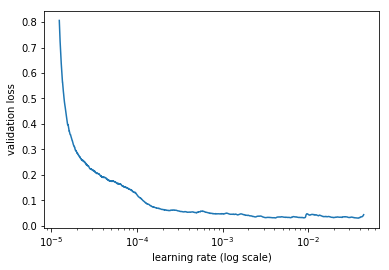

In [89]:
m.sched.plot(100)

### Sampled Data Set (run this section only with sampled dataset)

In [118]:
# Inputs
#  Pass in No. of continuous variables =  total Variables - Categoricals. NN knows how to create continuous and cat variables
#  Categorical variable dropouts ... .04
#  Output of last linear layer ... 1, predicting single number sales
#  Activations in first and second linear layers ... [1000,500]
#  Dropouts in first and second linear layers ... [.001,0.1]

m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),
                   0.04, 1, [1000,500], [0.001,0.01], y_range=y_range)
lr = 1e-3

In [119]:
m.fit(lr, 3, metrics=[exp_rmspe])

epoch      trn_loss   val_loss   exp_rmspe                       
    0      0.027075   0.026772   0.168136  
    1      0.020292   0.042733   0.178886                        
    2      0.018082   0.033591   0.161527                        


[array([0.03359]), 0.16152679955443033]

In [120]:
m.fit(lr, 5, metrics=[exp_rmspe], cycle_len=1)

epoch      trn_loss   val_loss   exp_rmspe                       
    0      0.011886   0.016945   0.120789  
    1      0.011497   0.016056   0.117751                        
    2      0.01111    0.014842   0.114942                        
    3      0.010293   0.014557   0.113945                         
    4      0.009217   0.014033   0.112515                         


[array([0.01403]), 0.11251475376501577]

In [121]:
m.fit(lr, 2, metrics=[exp_rmspe], cycle_len=4)

epoch      trn_loss   val_loss   exp_rmspe                       
    0      0.011715   0.018787   0.149207  
    1      0.009612   0.014667   0.114463                         
    2      0.008655   0.01321    0.110659                         
    3      0.006944   0.013313   0.110169                         
    4      0.010628   0.014148   0.122925                        
    5      0.008509   0.013768   0.110914                         
    6      0.007199   0.0136     0.110304                         
    7      0.006271   0.012801   0.108757                         


[array([0.0128]), 0.10875654820105955]

### All (Learn on the entire data set , not sampled)

In [133]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),
                   0.04, 1, [1000,500], [0.001,0.01], y_range=y_range)
lr = 1e-3

In [134]:
m.fit(lr, 1, metrics=[exp_rmspe])

epoch      trn_loss   val_loss   exp_rmspe                       
    0      0.014241   0.015422   0.124388  


[array([0.01542]), 0.12438843071519944]

In [135]:
m.fit(lr, 3, metrics=[exp_rmspe])

epoch      trn_loss   val_loss   exp_rmspe                       
    0      0.011781   0.012708   0.107947  
    1      0.009749   0.013042   0.105729                         
    2      0.009098   0.011467   0.101354                         


[array([0.01147]), 0.10135394351206994]

In [136]:
m.fit(lr, 5, metrics=[exp_rmspe], cycle_len=1)

epoch      trn_loss   val_loss   exp_rmspe                        
    0      0.007065   0.010563   0.097754  
    1      0.006993   0.010614   0.097826                         
    2      0.007411   0.010584   0.097618                         
    3      0.006514   0.010569   0.0975                           
    4      0.006186   0.010604   0.097359                         


[array([0.0106]), 0.09735854323381407]

In [137]:
m.fit(lr, 4, metrics=[exp_rmspe], cycle_len=1)

epoch      trn_loss   val_loss   exp_rmspe                        
    0      0.00653    0.010652   0.097382  
    1      0.006001   0.01058    0.097255                         
    2      0.006395   0.010368   0.096616                         
    3      0.006307   0.010474   0.096289                         


[array([0.01047]), 0.09628930141547118]

In [138]:
m.save('val0')

metrics : this is a custom metric which specifies a function to be called at the end of every epoch and prints out a result

By using all of the training data, we achieved a RMSPE around 0.08757 (Jeremy's result, presented in class). There is a big difference between public leader board and private leader board, but we are certainly in the top end of this competition.

Folks at Pinterest who build a very similar model for recommendations also said that when they switched from gradient boosting machines to deep learning, they did way less feature engineering and it was much simpler model which requires less maintenance. So this is one of the big benefits of using this approach to deep learning — you can get state of the art results but with a lot less work

So this is a technique for dealing with time series and structured data. Interestingly, compared to the group that used this technique (Entity Embeddings of Categorical Variables), the second place winner did way more feature engineering. The winners of this competition were actually subject matter experts in logistics sales forecasting so they had their own code to create lots and lots of features. Folks at Pinterest who build a very similar model for recommendations also said that when they switched from gradient boosting machines to deep learning, they did way less feature engineering and it was much simpler model which requires less maintenance. So this is one of the big benefits of using this approach to deep learning — you can get state of the art results but with a lot less work.

Question: Are we using any time series in any of these? [01:15:01] Indirectly, yes. As we just saw, we have a day of week, month of year, etc in our columns and most of them are being treated as categories, so we are building a distributed representation of January, Sunday, and so on. We are not using any classic time series techniques, all we are doing is true fully connected layers in a neural net. The embedding matrix is able to deal with things like day of week periodicity in a much richer way than than any standard time series techniques.

Question regarding the difference between image models and this model [01:15:59]: There is a difference in a way we are calling get_learner. In imaging we just did Learner.trained and pass the data:

For these kinds of models, in fact for a lot of the models, the model we build depends on the data. In this case, we need to know what embedding matrices we have. So in this case, the data objects creates the learner (upside down to what we have seen before):

## Methodology Summary

Step 1   
- list the categorical variable names
- list continuouis variable names
- Put in pandas dataframe  

Step 2 - list of row index in validation set ... val_idx  
Step 3 - call ColumnarModelData.from_data_frame  
Step 4 - embeddings matrix  
Step 5 - call md.get_learner() ... you can use the exact parameters above fiddle if over or under fits then   fiddle with parameters
Step 6 - call m.fit ... 

### Discussion 


What is drop out doing in this case
- output of linear layer is rank 1 tensor ... e.g., drop 50%
- similar with embeddings vector ... e.g., drop 50%

What's the downside. Almost know one using this, why not. 

**Question:** How to use data augmentation for this type of data, and how does dropout work? [01:18:59] No idea. Jeremy thinks it has to be domain-specific, but he has never seen any paper or anybody in industry doing data augmentation with structured data and deep learning. He thinks it can be done but has not seen it done. What dropout is doing is exactly the same as before.


Data Augmentation
 - will be domain specific. Have not seen it done in the industry with structured data

#### What's the benefit of DL on Structured Data
- Academia not doing much in structured data, because academia not interested in publishing
- Prior to Fastai, you had to write all the custom code. 
- With Fastai now you can essentially do it with 6 lines of code
- Should be new opportunities to solve problems that had been previously done with ML
- Jeremy working on structured DL models for about 1 year. This class is the first time there is half a dozen people in the world using it. 
- There is a post instacart on what they are doing
- O'Reilly AI video


### Test (run this on the test data set ... on either sampled or all data set)

- Load the model and predict


### Test ... define the model, load, and predict

In [139]:
md = ColumnarModelData.from_data_frame(PATH, val_idx, df, yl.astype(np.float32), cat_flds=cat_vars, bs=128,
                                       test_df=df_test)

m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),
                   0.04, 1, [1000,500], [0.001,0.01], y_range=y_range)

In [141]:
m.load('val0')

In [142]:
x,y=m.predict_with_targs()

In [143]:
exp_rmspe(x,y)

0.09997347595447578

In [144]:
pred_test=m.predict(True)

In [145]:
pred_test = np.exp(pred_test)

In [146]:
joined_test['Sales']=pred_test

In [147]:
csv_fn=f'{PATH}tmp/sub.csv'

In [148]:
joined_test[['Id','Sales']].to_csv(csv_fn, index=False)

In [149]:
FileLink(csv_fn)

/home/paperspace/fastai/courses/dl1/data/rossmann/tmp/sub.csv

In [150]:
pred_test

array([[ 4504.1655],
       [ 7509.4805],
       [ 9319.568 ],
       [ 7566.9277],
       [ 7453.5645],
       [ 6075.2817],
       [ 7460.306 ],
       [ 8097.3286],
       [ 5260.166 ],
       [ 5864.3965],
       [ 7239.9814],
       [ 8378.206 ],
       [ 7408.302 ],
       [ 9553.477 ],
       [ 5921.4097],
       [ 5163.6865],
       [ 5904.2617],
       [10052.505 ],
       [10589.701 ],
       [ 9904.076 ],
       ...,
       [ 7281.3403],
       [13741.914 ],
       [ 6217.177 ],
       [ 5366.7993],
       [ 7806.3457],
       [ 8492.542 ],
       [ 3249.8674],
       [ 8892.701 ],
       [ 7109.9014],
       [ 5303.055 ],
       [ 6111.211 ],
       [ 4994.694 ],
       [ 2966.486 ],
       [ 5946.6777],
       [ 3911.0332],
       [ 3011.966 ],
       [ 7573.714 ],
       [ 5957.5024],
       [24057.578 ],
       [ 6723.2686]], dtype=float32)

## Prediction

In [151]:
md = ColumnarModelData.from_data_frame(PATH, val_idx, df, yl.astype(np.float32), cat_flds=cat_vars, bs=128,
                                       test_df=df_test)

In [152]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),
                   0.04, 1, [1000,500], [0.001,0.01], y_range=y_range)

In [153]:
m.load('val0')

In [154]:
# based on notes from Anze below

# create ColumnarDataSet from DataFrame (df)
dummy_y=len(df_test)*[0]
cds = ColumnarDataset.from_data_frame(df_test,cat_vars)

dl = DataLoader(cds,batch_size=128)

predictions = m.predict_dl(dl)
predictions=np.exp(predictions)
predictions

array([[ 4504.1655],
       [ 7509.4805],
       [ 9319.568 ],
       [ 7566.9277],
       [ 7453.5645],
       [ 6075.2817],
       [ 7460.306 ],
       [ 8097.3286],
       [ 5260.166 ],
       [ 5864.3965],
       [ 7239.9814],
       [ 8378.206 ],
       [ 7408.302 ],
       [ 9553.477 ],
       [ 5921.4097],
       [ 5163.6865],
       [ 5904.2617],
       [10052.505 ],
       [10589.701 ],
       [ 9904.076 ],
       ...,
       [ 7281.3403],
       [13741.914 ],
       [ 6217.177 ],
       [ 5366.7993],
       [ 7806.3457],
       [ 8492.542 ],
       [ 3249.8674],
       [ 8892.701 ],
       [ 7109.9014],
       [ 5303.055 ],
       [ 6111.211 ],
       [ 4994.694 ],
       [ 2966.486 ],
       [ 5946.6777],
       [ 3911.0332],
       [ 3011.966 ],
       [ 7573.714 ],
       [ 5957.5024],
       [24057.578 ],
       [ 6723.2686]], dtype=float32)

### Prediction  ... options for prediction based on notes from fastai forum
https://forums.fast.ai/t/understanding-columnarmodeldata-from-data-frame-from-rossman/8140/4

My workflow is very usual:

train NN on columnar data  

a)  load train/val set  
b) do ‘preprocessing’ (i.e. standardize each column)  
c) initialize ColumnarModelData and get the learner  
d) use lr_find; SGDR;  
e) save model at the end
  

go to local machine  
a) load sample  
b) do 'preprocessing’  
c) initialize ColumnarModelData using loaded sample and get the learner  
d) load model trained on AWS  
e) do classification on loaded sample    

In order to do step 2b) I need the mapper from step 1b) and pass it as an argument in proc_df function, right? So I need to serialize the mapper as well.  

Is step 2c correct?  


Yeap, for step 2c, you would need to pass in the sample data from proc_df into ColumnarModelData. After that, get learner, load the model, and run the prediction.

To predict the test sets, I have used the workaround steps below, worked fine for me so far.
http://forums.fast.ai/t/structured-learner/8224/3


What I am doing for now as a temp solution is (at least works):

### kcturgutflu
Tune model with train and val sets.
* Store these hyperparameters (lr, dimension of embeddings)
* Combine train and test (add target column to test)
* Run model as you are running with val
* Make predictions with m.predict()

Note: I am very fascinated by expressing categorical variables in Eucledian spaces, especially after seeing some t-SNE visualizations on them. Very cool :smiley:


### Weather and tred corresponding to test
As for weather and googletrend data, I think we should have it since it’s the only way 3rd place winners to had a submission. So it must be somewhere in there

You should be able to grab it here https://github.com/entron/entity-embedding-rossmann/tree/kaggle


### Anze ... there’s another solution:

create ColumnarDataSet from DataFrame (df)  
cds = ColumnarDataset.from_data_frame(df,cat_flds=[…put your cat vars here…],y=dummy_y)

create DataLoader from ColumnarDataSet  
dl = DataLoader(cds)  

make predictions for DataLoader  
predictions = m.predict_dl(dl)  

### arjunrajkumar ... Hi Anze,

Just a little lost here. How do you pass the test data while using these three steps?  
Do I have to create a new df containing only the test sets using the proc_df command, 
and then make sure that that df should have the same columns as the ones on training?  

### Anze Zupanc
@arjunrajkumar Exactly.

## RF

In [128]:
from sklearn.ensemble import RandomForestRegressor

In [129]:
((val,trn), (y_val,y_trn)) = split_by_idx(val_idx, df.values, yl)

In [130]:
mrf = RandomForestRegressor(n_estimators=40, max_features=0.99, min_samples_leaf=2,
                          n_jobs=-1, oob_score=True)
mrf.fit(trn, y_trn);

In [131]:
preds = mrf.predict(val)
mrf.score(trn, y_trn), m.score(val, y_val), m.oob_score_, exp_rmspe(preds, y_val)

(0.9822924861623946,
 0.931704191178399,
 0.9247724900452019,
 0.10854763755522956)

### Rossman test DL methodology

Look at Rossman added test set ... all lines should now contain test comparisons

Understand how well the method works ... 

- Code does not run top to bottom 

- apply_cats rather than test_cats to make sure same categorical codes

- create model data object pass in the test data

**Public and Private Kaggle Scores**  
When finish trining it then call predict, say True to say test set

Then pass to Kaggle 

Public score 0.103 ... 300th place looks awful 
Privat score 0.107 ... 5th 

If you are competing and have not thoughtfully created validation set of your own and relying on public leaderboard , you may look good in public, but in private not look so good. 


**Iceberg competition**  

large percentage of public leader board synthetically generated data augmentation data.

your validation set should be very helpful

### Rossman test DL methodology

There are some nice Kernals in Rossman. Especially if you are doing the ecuador grocery competiton, some of these will be helpful. 

<img src="./RossmanSundays.png" style='width:300 px;height:300 px;'>

One of them showed for sales of Sundays and non-Sundays do and don't look similar.

<img src="./RossmanStoreClosures.png" style='width:300 px;height:300 px;'>

Rossman 3rd place winnersRossman, whose approach we used. Cool vilsualization showing that just after or before the store closes there are very high demand. The 3rd place winner deleted store close dates. Surely they would have won otherwise. There model was trying to fit to these extremes, that it had no predictive data for. 

## Looking through Fastai Code

**Get_learner**  


... got the model, find out what kind of model
   ```
  ../fastai/courses/dl1/column_data.py
  
   uses PyTorch mixedInputModel wraps it in the Fastai Structured learner which wraps the model and the data together
   
   MixedInputModel
   ```

**Note MixedModel (Torch)**  
- always expects categorical (can be empty list) and continuous and will work
- some of thise hacky cases will be fixed with PyTorch 0.4 which will handle rank0 Tensor 

**PyTorch registers list**  
nn.ModuleList ... register everything in list to be part of the model


Don't treat these as black boxes ... play withg them paste into Jupyter notebook, modify and create your own versions